In [1]:
#Importing libraries
import numpy as np
import matplotlib.pyplot as plt

import mne
from pathlib import Path

from deepjr.simulation import plot_jr_results, run_jr_simulation, apply_C_factor

# Genral Information

These are the values for the Jansen Rit Model which are available in the literature, particularly from [this paper](https://mathematical-neuroscience.springeropen.com/articles/10.1186/s13408-017-0046-4/tables/1). The value of $v_{max}$ was corrected from 5 Hz to 50 Hz, a more reasonable value and a value that compatible with other publications (e.g., [this one](https://link.springer.com/article/10.1007/s10827-013-0493-1#Tab1)). Minimum and maximum values are defined as per [the code of The Virtual Brain](https://docs.thevirtualbrain.org/_modules/tvb/simulator/models/jansen_rit.html).




| Parameter  | Description                                                                  | Typical value | min value | max value |
| ---------- | ---------------------------------------------------------------------------- | ------------- | --------- | --------- |
| $A_e$      | Average excitatory synaptic gain                                             | 3.25 mV       | 2.6 mV    | 9.75 mV   | 
| $A_i$      | Average inhibitory synaptic gain 	                                        | 22 mV         | 17.6 mV   | 110.0 mV  |
| $b_e$	     | Inverse of the time constant of excitatory postsynaptic potential            | 100 Hz        | 50 Hz     | 150 Hz    |
| $b_i$	     | Inverse of the time constant of inhibitory postsynaptic potential            | 50 Hz         | 25 Hz     | 75 Hz     |
| $C$	     | Average number of synapses between the populations 	                        | 135           | 65        | 1350      |
| $a_1$      | Average probability of synaptic contacts in the feedback excitatory loop     | 1.0           | 0.5       | 1.5       |
| $a_2$	     | Average probability of synaptic contacts in the slow feedback excitatory loop| 0.8           | 0.4       | 1.2       |
| $a_3$	     | Average probability of synaptic contacts in the feedback inhibitory loop     | 0.25          | 0.125     | 0.375     |
| $a_4$	     | Average probability of synaptic contacts in the slow feedback inhibitory loop| 0.25          | 0.125     | 0.375     |
| $v_{max}$  | Maximum firing rate of the neural populations (max. of sigmoid fct.)         | 50 Hz         |     -     |     -     | 
| $v_0$      | Value for which 50% of the maximum firing rate is attained 	                | 6 mV          | 3.12 mV   | 6.0 mV    |




In [2]:
# Default Parameters from Jansen RIT model
C = 135
parameters = {"A_e": 3.25 * 1e-3,
              "A_i": 22 * 1e-3,
              "b_e": 100,
              "b_i": 50,
              "C" : 135,
              "a_1": 1.0,
              "a_2": 0.8,
              "a_3": 0.25,
              "a_4": 0.25,
              "v_max": 50 * 1e-3,
              "v_0": 6 * 1e-3}

parameter_ranges = {
    'A_e': (2.6 * 1e-3, 9.75 * 1e-3),
    'A_i': (17.6 * 1e-3, 110.0 * 1e-3),
    'b_e': (5, 150),
    'b_i': (25, 75),
    'C': (65, 1350),
    'a_1': (0.5, 1.5),
    'a_2': (0.4, 1.2),
    'a_3': (0.125, 0.375),
    'a_4': (0.125, 0.375)
}



### Getting and info structure, a montage, and a noise covariance matrix for simulation

In [3]:
sfreq = 1000
dt = 1/sfreq
montage = mne.channels.make_standard_montage('biosemi64')
info = mne.create_info(montage.ch_names, sfreq, ch_types="eeg")
info.set_montage(montage)
noise_cov = mne.make_ad_hoc_cov(info)

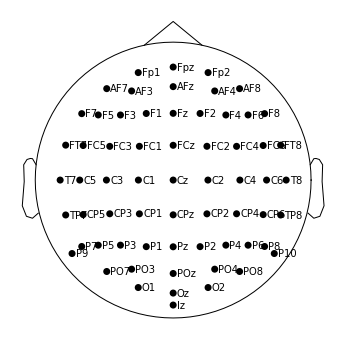

In [4]:
# Plot the montage with adjusted font size
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
mne.viz.plot_montage(montage, scale_factor=20, axes=ax, show_names=True)

fig.savefig('montage_plot.png', dpi=300, bbox_inches='tight')

# Setting up the forward model

In [5]:
fwd_fname = "fsaverage-fwd.fif.gz"
if not Path(fwd_fname).exists():
    src = mne.setup_source_space('fsaverage', spacing='oct6', surface='white')
    model = mne.make_bem_model(subject="fsaverage")
    bem = mne.make_bem_solution(model)
    fwd = mne.make_forward_solution(info, "fsaverage", src, bem)
    fwd.save(fwd_fname)

fwd = mne.read_forward_solution(fwd_fname)

Reading forward solution from /Users/christian/Code/Jansen-Rit-Model-Benchmarking-Deep-Learning/notebooks/fsaverage-fwd.fif.gz...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (8196 sources, 64 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


### Generate stimulus

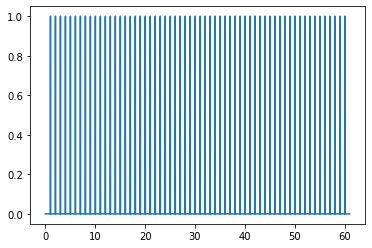

In [6]:
from deepjr.simulation import generate_events, generate_stimulus

# Stimuli parameters
isi = 1  # inter-stimulus interval, in seconds
nb_trial = 60  # Number of trials
stim_dur = 0.05  # Stimulus duration, in seconds
transient_dur = 0.8  # Duration of transient 

# Epoch times
tmin = -0.2
tmax = 0

# Getting events
sim_duration = transient_dur - tmin + nb_trial*isi
events = generate_events(inter_trial_freq=1/isi, 
                         dt=dt, 
                         t_base=transient_dur - tmin, 
                         t_tot=sim_duration)

# Calculate the stimulus signal
I, Ip, Ii, time = generate_stimulus(dt, sim_duration, events, return_time=True)

plt.plot(time, I)

### Run an example of simulation

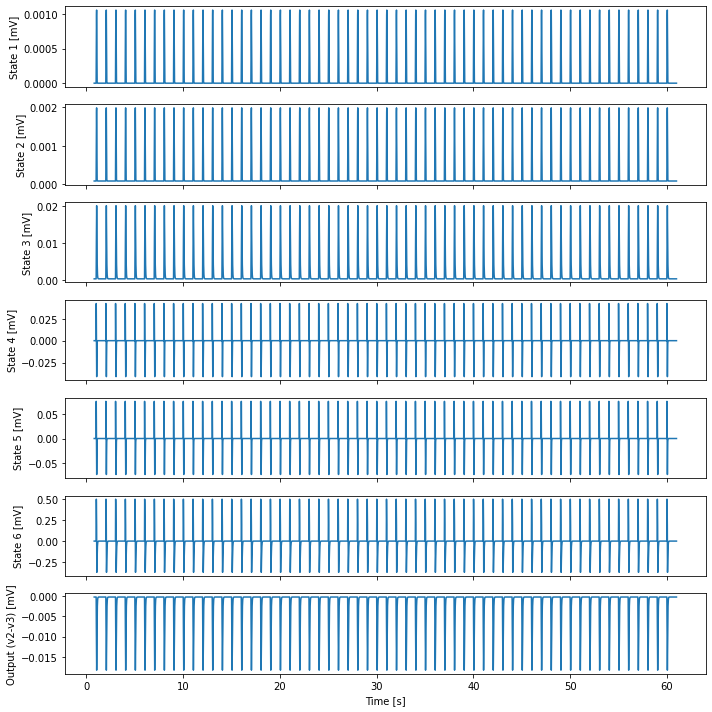

In [7]:
jr_noise_sd = 0.0
nb_samples = len(I) #Length of the simulation array
jr_noise = jr_noise_sd * np.random.randn(nb_samples)  # Noise
y = run_jr_simulation(dt, nb_samples, Ii, Ip, jr_noise, apply_C_factor(parameters))

states = []
outputs =[]

points_to_skip = int(transient_dur/dt)
states.append(y[:, points_to_skip:])
outputs.append((y[1] - y[2])[points_to_skip:])
time_axis = np.linspace(0, sim_duration, nb_samples)
plot_jr_results(time_axis, states, outputs, points_to_skip);

## EEG simulations

In [8]:
#run for all parameters seprately

# update the directory here.. 
base_path = Path('deepjr_training_data')
base_path.mkdir(exist_ok=True)
method = 'normal'  # there is an option of 'linear' -- for linearly space sampling
nb_simulations = 1000 # how many recordings you want to simulate
noise_fact = [1.0]

In [9]:
from deepjr.simulation import simulate_for_parameter

mne.set_log_level(verbose=False)

# Simulation per parameter calling the function
simulate_for_parameter(parameter_ranges, nb_samples, Ii, Ip, jr_noise,  dt, 
                       transient_dur, info, fwd, events, 
                       ground_truth=parameters, method=method, 
                       N=nb_simulations, noise_factor=1.0, noise_cov=noise_cov,
                       base_path=base_path, use_tqdm=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/christian/Code/Jansen-Rit-Model-Benchmarking-Deep-Learning/deepjr/simulation.py:109: RuntimeWarning: overflow encountered in exp
  y[4, ii] = y[4, ii - 1] + dt * (kA * ka * A * a * (p[ii - 1] + Ip[ii - 1] + C2 * vm / (1 + np.exp(r * (v0 - C1 * y[0, ii - 1])))) - 2 * ka * a * y[4, ii - 1] - ka**2 * a**2 * y[1, ii - 1])
/Users/christian/Code/Jansen-Rit-Model-Benchmarking-Deep-Learning/deepjr/simulation.py:108: RuntimeWarning: overflow encountered in exp
  y[3, ii] = y[3, ii - 1] + dt * (A * a * (Ii[ii - 1] + vm / (1 + np.exp(r * (v0 - (y[1, ii - 1] - y[2, ii - 1]))))) - 2 * a * y[3, ii - 1] - a**2 * y[0, ii - 1])
/Users/christian/Code/Jansen-Rit-Model-Benchmarking-Deep-Learning/deepjr/simulation.py:110: RuntimeWarning: overflow encountered in exp
  y[5, ii] = y[5, ii - 1] + dt * (B * b * (Ip[ii - 1] + C4 * vm / (1 + np.exp(r * (v0 - C3 * y[0, ii - 1])))) - 2 * b * y[5, ii - 1] - b**2 * y[2, ii - 1])
/Users/christian/Code/Jansen-Rit-Model-Benchmarking-Deep-Learning/deepjr/simulatio